In [1]:
# Imports 
import pdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
os.environ['pyna_language'] = 'python'
from pyNA.pyna import pyna

In [2]:
def read_controls_file(var, file_name):

    text = open(file_name, "r")
    file = text.read()
    file = file.replace('\n', ' ')

    def find(s, ch):
        return [i for i, ltr in enumerate(s) if ltr == ch]

    if var == 'k':
        control = np.fromstring(file, sep=' ')

    else:
        i_s = find(file, '[')
        i_e = find(file, ']')
        control = np.zeros((np.size(i_s), np.size(np.fromstring(file[i_s[0]+1:i_e[0]], sep=' '))))

        for i in np.arange(np.size(i_s)):
            control[i,:] = np.fromstring(file[i_s[i]+1:i_e[i]], sep=' ')
        
    return control

def read_optimizer_control_inputs(directory_name = ''):

    file_name_k          = directory_name + 'inputs_k.txt'
    file_name_alpha      = directory_name + 'inputs_alpha.txt'
    file_name_TS         = directory_name + 'inputs_TS.txt'
    file_name_theta_flaps= directory_name + 'inputs_theta_flaps.txt'
    file_name_levels_int = directory_name + 'outputs_levels_int.txt'
    
    return_lst = []
    
    # Read objective function
    with open(file_name_levels_int) as f:
        lines_lvl = f.readlines()

    # Extract EPNL
    levels_int = np.zeros((len(lines_lvl), 2))
    for i, line in enumerate(lines_lvl):
        levels_int[i,:] = np.fromstring(line[1:-2], sep=', ')

    return_lst.append(levels_int)
    
    return_lst.append(read_controls_file('k', file_name_k))
    return_lst.append(read_controls_file('alpha', file_name_alpha))
    return_lst.append(read_controls_file('TS', file_name_TS))
    return_lst.append(read_controls_file('theta_flaps', file_name_theta_flaps))
    
    return return_lst

def plot_optimizer_control_inputs(levels_int, k=None, alpha=None, TS=None, theta=None, epnl_constraint=100.):
    
    nvars = 1
    if np.size(k) > 1:
        nvars = nvars + 1    
    if np.size(alpha) > 1:
        nvars = nvars + 1
    if np.size(TS) > 1:
        nvars = nvars + 1
    if np.size(theta) > 1:
        nvars = nvars + 1
    
    # Plot
    fig, ax = plt.subplots(nvars,2,figsize=(16,3.1*nvars))
    plt.style.use('../utils/plot.mplstyle')

    # 1. Objective    
    ax[0,0].plot([0, data['iter'].values[-1]+10], [epnl_constraint, epnl_constraint], 'k', linewidth=1)
    ax[0,0].plot(np.linspace(0, data['iter'].values[-1], np.size(levels_int[:,0])), levels_int[:,0], color='tab:blue')
    ax[0,0].grid(True)
    ax[0,0].set_xlabel('Iteration number [-]')
    ax[0,0].set_ylabel('$EPNL_{lateral}$ \n [EPNdB]')
    
    ax[0,1].plot([0, data['iter'].values[-1]+10], [np.mean(levels_int[-100:,1]), np.mean(levels_int[-100:,1])], 'k', linewidth=1)
    ax[0,1].plot(np.linspace(0, data['iter'].values[-1], np.size(levels_int[:,1])), levels_int[:,1])
    ax[0,1].grid(True)
    ax[0,1].set_xlabel('Iteration number [-]')
    ax[0,1].set_ylabel('$EPNL_{flyover}$ \n [EPNdB]')
        
    # 1. Rotation speed ratio
    if np.size(k) > 1:
        ax[1,0].plot([0, data['iter'].values[-1]+10], [np.mean(k[-100:]), np.mean(k[-100:])], 'k', linewidth=1)
        ax[1,0].plot(np.linspace(0, data['iter'].values[-1], np.size(k)), k, color='tab:blue')
        ax[1,0].set_xlabel('Iteration number [-]')
        ax[1,0].set_ylabel('$k_{rot}$ [-]')
        ax[1,1].axis('off')
        
    # 2. alpha
    if np.size(alpha) > 1:
        for i in np.arange(np.shape(alpha)[1]):
            ax[2,0].plot(np.linspace(0, data['iter'].values[-1], np.size(alpha[:,i])), alpha[:,i])
        ax[2,0].set_ylabel(r'$\alpha_i$ [deg]')
        ax[2,0].set_xlabel('Iteration number [-]')

        N = 200
        ax[2,1].plot(alpha[-1,:], '-', label='Final iteration')
        ax[2,1].plot(np.mean(alpha[-N:,:], axis=0), '--', label='Average over all iterations')
        ax[2,1].set_xlabel('$t_{source}$ [s]')
        ax[2,1].set_ylabel(r'$\alpha$ [deg]')
        ax[2,1].legend(fontsize=14, frameon=False)

    # 3. Thrust setting
    if np.size(TS) > 1:
        for i in np.arange(np.shape(TS)[1]):
            ax[3,0].plot(np.linspace(0, data['iter'].values[-1], np.size(TS[:,i])), TS[:,i])
        ax[3,0].set_ylabel('$TS_i$ [-]')
        ax[3,0].set_xlabel('Iteration number [-]')

        N = 200
        ax[3,1].plot(TS[-1,:], '-', label='Final iteration')
        ax[3,1].plot(np.mean(TS[-N:,:], axis=0), '--', label='Average over all iterations')
        ax[3,1].set_xlabel('$t_{source}$ [s]')
        ax[3,1].set_ylabel('TS [-]')
        ax[3,1].legend(fontsize=14, frameon=False, loc='upper right')

    # 5. Flap deflection angle
    if np.size(theta) > 1:
        for i in np.arange(np.shape(theta)[1]):
            ax[4,0].plot(np.linspace(0, data['iter'].values[-1], np.size(theta[:,i])), theta[:,i])

        ax[4,0].set_ylabel(r'$\theta$ [deg]')
        ax[4,0].set_xlabel('Optimization iteration N')

        ax[4,1].plot(theta[-1,:], '-', label='Final iteration')
        ax[4,1].plot(np.mean(theta[-N:,:], axis=0), '--', label='Average over all iterations')
        ax[4,1].set_xlabel('$t_{source}$ [s]')
        ax[4,1].set_ylabel(r'$\theta$ [deg]')
        ax[4,1].grid(True)
        ax[4,1].legend(fontsize=14, frameon=False, loc='upper right')

    plt.subplots_adjust(wspace=0.3, hspace=0.55)

    return 

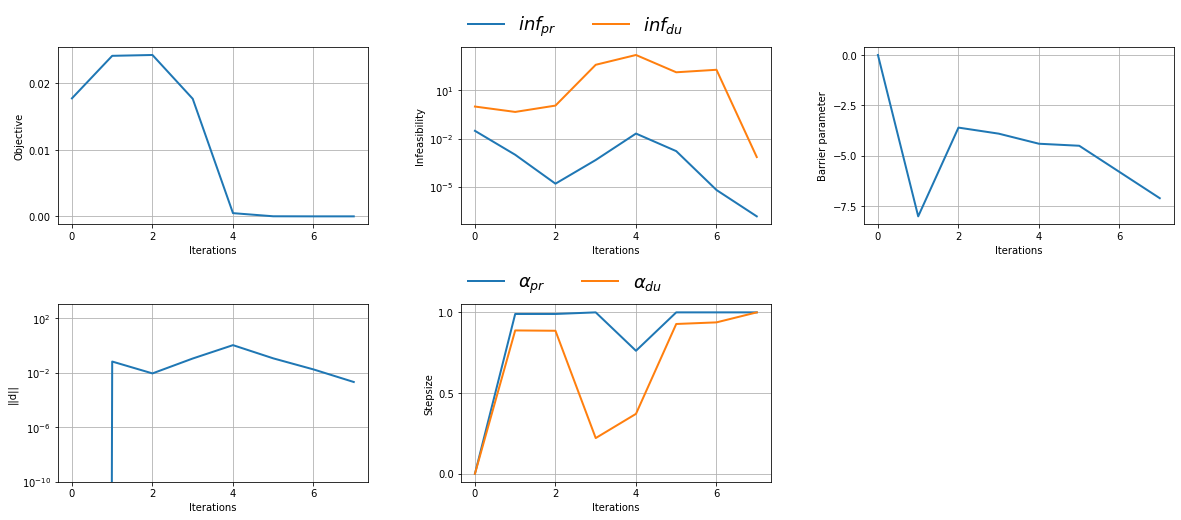

In [3]:
# IPOPT output 
py = pyna()
data = py.plot_optimizer_convergence_data('../cases/stca/output/PTCB/V2/IPOPT_trajectory_convergence.out')
# data = py.plot_optimizer_convergence_data('../cases/stca/output/PTCB/icao_limits/V2/IPOPT_trajectory_convergence.out')

In [4]:
# Load files
levels_int, k, alpha, TS, theta_flaps = read_optimizer_control_inputs('../cases/stca/output/PTCB/V2/')

plot_optimizer_control_inputs(levels_int, k, alpha, TS, theta_flaps, epnl_constraint=93.88114249370162-0.5)

FileNotFoundError: [Errno 2] No such file or directory: '../cases/stca/output/PTCB/V2/outputs_levels_int.txt'

In [290]:
file_name_k = '../cases/stca/output/PTCB_latlim/V2/' + 'inputs_k.txt'

text = open(file_name_k, "r")
file = text.read()

In [234]:

for i in np.arange(len(lines_alpha)):
    if lines_alpha[i][-2] == ']':
        print(np.fromstring(lines_alpha[i][1:-2], sep=' '))
    else:
        print(np.fromstring(lines_alpha[i][1:-1], sep=' '))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1.   1.   0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75]
[0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75]
[0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75]
[0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75]
[0.75 0.75 0.75 0.75]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1.   1.   0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75]
[0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75]
[0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75]
[0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75]
[0.75 0.75 0.75 0.75]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[0.75249999 0.75249999 0.75249999 0.75249999 0.75249999 0.75249999]
[0.75249999 0.75249999 0.75249999 0.

[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1.         0.85811753 0.77656839 0.7553526  0.76303361 0.76817489]
[0.77077645 0.77129051 0.7701693  0.76741283 0.76900796 0.78094156]
[0.80321364 0.82660263 0.84188697 0.84906666 0.84475853 0.82557938]
[0.79152922 0.75925776 0.74541468 0.75       0.75       0.75      ]
[0.75 0.75 0.75 0.75 0.75 0.75]
[0.75 0.75 0.75 0.75 0.75 0.75]
[0.75 0.75 0.75 0.75 0.75 0.75]
[0.75 0.75 0.75 0.75 0.75 0.75]
[0.75 0.75 0.75 0.75 0.75 0.75]
[0.75 0.75 0.75 0.75]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1.         0.88199559 0.80973942 0.7832315  0.7792407  0.77453592]
[0.76911716 0.76668755 0.77095024 0.78190523 0.79528964 0.80684057]
[0.81655803 0.82485918 0.83216121 0.83846411 0.83686228 0.8204501 ]
[0.78922758 0.75911717 0.74604131 0.75       0.75       0.75      ]
[0.75 0.75 0.75 0.75 0.75 0.75]
[0.75 0.75 0.75 0.75 0.75 0.75]
[0.75 0.75

[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1.         0.89564633 0.82496179 0.78794637 0.77225838 0.76555609]
[0.76783951 0.7730834  0.77526252 0.77437687 0.77579863 0.78489998]
[0.80168091 0.82161405 0.84017199 0.85735474 0.86255518 0.84516618]
[0.80518776 0.76487369 0.74647777 0.75       0.75       0.75      ]
[0.75 0.75 0.75 0.75 0.75 0.75]
[0.75 0.75 0.75 0.75 0.75 0.75]
[0.75 0.75 0.75 0.75 0.75 0.75]
[0.75 0.75 0.75 0.75 0.75 0.75]
[0.75 0.75 0.75 0.75 0.75 0.75]
[0.75 0.75 0.75 0.75]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1.         0.895109   0.82217575 0.78120026 0.76182267 0.75368315]
[0.7567817  0.76503414 0.7723563  0.77874817 0.78564877 0.79449712]
[0.80529323 0.81776718 0.83164907 0.84693892 0.85253833 0.8373489 ]
[0.80137065 0.76474769 0.74762414 0.75       0.75       0.75      ]
[0.75 0.75 0.75 0.75 0.75 0.75]
[0.75 0.75 0.75 0.75 0.75 0.75]
[0.75 0.75 0.75 0.75 0.75 0.75]
[0.75 0.75 0.75 0.

[0.75 0.75 0.75 0.75 0.75 0.75]
[0.75 0.75 0.75 0.75 0.75 0.75]
[0.75 0.75 0.75 0.75 0.75 0.75]
[0.75 0.75 0.75 0.75 0.75 0.75]
[0.75 0.75 0.75 0.75]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1.         0.9011602  0.83044611 0.7878577  0.76464217 0.75204668]
[0.75007124 0.75448573 0.76106005 0.76979419 0.78110578 0.79541244]
[0.81271417 0.82916278 0.84091009 0.84795611 0.84509999 0.82714093]
[0.79407893 0.76210561 0.74741264 0.75       0.75       0.75      ]
[0.75 0.75 0.75 0.75 0.75 0.75]
[0.75 0.75 0.75 0.75 0.75 0.75]
[0.75 0.75 0.75 0.75 0.75 0.75]
[0.75 0.75 0.75 0.75 0.75 0.75]
[0.75 0.75 0.75 0.75 0.75 0.75]
[0.75 0.75 0.75 0.75]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1.         0.8924036  0.81971188 0.78192484 0.76482908 0.75421122]
[0.75007124 0.75128084 0.75671171 0.76636385 0.77824277 0.79035399]
[0.80269751 0.81508999 0.82734808 0.8394718  0.84260098 0.82

[1. 1. 1. 1. 1. 1.]
[1.         0.88334727 0.81453768 0.79357123 0.79403875 0.78953105]
[0.78004813 0.77338397 0.77733253 0.7918938  0.8106458  0.82716655]
[0.84145604 0.84923054 0.84620633 0.8323834  0.81279584 0.79247769]
[0.77142897 0.75477197 0.74762898 0.75       0.75       0.75      ]
[0.75 0.75 0.75 0.75 0.75 0.75]
[0.75 0.75 0.75 0.75 0.75 0.75]
[0.75 0.75 0.75 0.75 0.75 0.75]
[0.75 0.75 0.75 0.75 0.75 0.75]
[0.75 0.75 0.75 0.75 0.75 0.75]
[0.75 0.75 0.75 0.75]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1.         0.88569045 0.8192109  0.80056135 0.80276626 0.7988501 ]
[0.78881286 0.7801625  0.78040696 0.78954626 0.8041884  0.8209414 ]
[0.83980526 0.85450737 0.85877511 0.85260847 0.83742213 0.81463077]
[0.78423438 0.7576313  0.74621984 0.75       0.75       0.75      ]
[0.75 0.75 0.75 0.75 0.75 0.75]
[0.75 0.75 0.75 0.75 0.75 0.75]
[0.75 0.75 0.75 0.75 0.75 0.75]
[0.75 0.75 0.75 0.75 0.75 0.75]
[0.75 0.75 0.75 0.75 0.75 

[0.75 0.75 0.75 0.75 0.75 0.75]
[0.75 0.75 0.75 0.75 0.75 0.75]
[0.75 0.75 0.75 0.75 0.75 0.75]
[0.75 0.75 0.75 0.75]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1.         0.88921741 0.81759421 0.78513041 0.77382766 0.76568762]
[0.76071029 0.76026059 0.76570342 0.77703878 0.79122836 0.80523385]
[0.81905526 0.8292132  0.83222827 0.82810047 0.81725848 0.80013099]
[0.77671799 0.75604549 0.74713949 0.75       0.75       0.75      ]
[0.75 0.75 0.75 0.75 0.75 0.75]
[0.75 0.75 0.75 0.75 0.75 0.75]
[0.75 0.75 0.75 0.75 0.75 0.75]
[0.75 0.75 0.75 0.75 0.75 0.75]
[0.75 0.75 0.75 0.75 0.75 0.75]
[0.75 0.75 0.75 0.75]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1.]
[1.         0.88661734 0.8149658  0.78504538 0.77672534 0.76987491]
[0.76449409 0.76266959 0.76648812 0.77594966 0.78890136 0.80319031]
[0.81881653 0.83129057 0.83612295 0.83331368 0.82290848 0.80495307]
[0.77944743 0.75665499 0

In [256]:
#get file object reference to the file


#read content of file to string


In [276]:
data

'[1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.  1.   1.   0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75  0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75  0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75  0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75  0.75 0.75 0.75 0.75] [1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.  1.   1.   0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75  0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75  0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75  0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75  0.75 0.75 0.75 0.75] [1.         1.         1.         1.         1.         1.  1.         1.         1.         1.         1.     

In [263]:
i_

[0,
 444,
 888,
 1796,
 2704,
 3612,
 4520,
 5428,
 6336,
 7244,
 8152,
 9060,
 9968,
 10875,
 11783,
 12691,
 13599,
 14507,
 15415,
 16323,
 17230,
 18138,
 19045,
 19951,
 20859,
 21767,
 22674,
 23582,
 24490,
 25398,
 26306,
 27214,
 28120,
 29026,
 29934,
 30842,
 31750,
 32658,
 33566,
 34474,
 35381,
 36289,
 37196,
 38103,
 39011,
 39919,
 40827,
 41735,
 42642,
 43550,
 44458,
 45366,
 46273,
 47180,
 48088,
 48996,
 49902,
 50810,
 51718,
 52626,
 53534,
 54442,
 55350,
 56258,
 57166,
 58074,
 58982,
 59890,
 60798,
 61705,
 62613,
 63521,
 64428,
 65336,
 66244,
 67152,
 68058,
 68966,
 69874,
 70782,
 71690,
 72598,
 73505,
 74413,
 75321,
 76229,
 77137,
 78045,
 78953,
 79861,
 80769,
 81677,
 82584,
 83492,
 84396,
 85304,
 86211,
 87119,
 88027,
 88934,
 89842,
 90750,
 91658,
 92566,
 93473,
 94380,
 95288,
 96196,
 97104,
 98012,
 98920,
 99828,
 100736,
 101643,
 102550,
 103456,
 104364,
 105272,
 106179,
 107087,
 107994,
 108902,
 109810,
 110718,
 111626,
 1125

In [ ]:
levels_int1, _, _, _, _ = read_optimizer_control_inputs('../cases/stca/output/PTCB/Vmax/')

(82.0, 85.0)

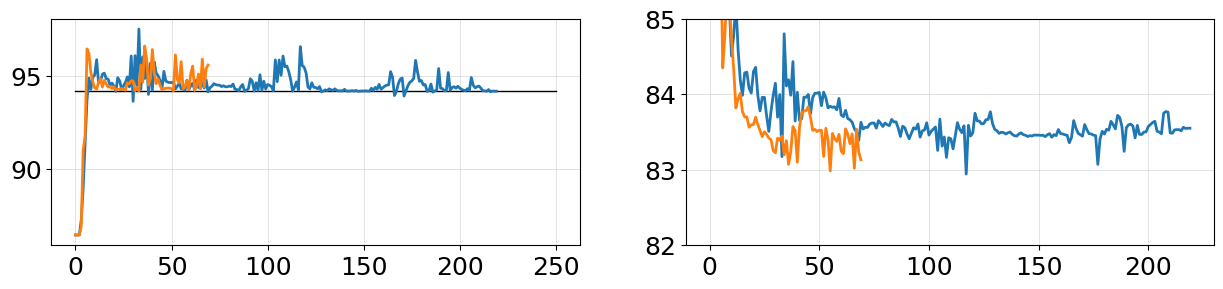

In [77]:
fig, ax = plt.subplots(1,2, figsize=(15,3))
ax[0].plot([0,250], [94.18048648759601, 94.18048648759601], 'k', linewidth=1)
ax[0].plot(levels_int1[:,0])
ax[0].plot(levels_int[:,0])

ax[1].plot(levels_int1[:,1])
ax[1].plot(levels_int[:,1])
ax[1].set_ylim([82,85])


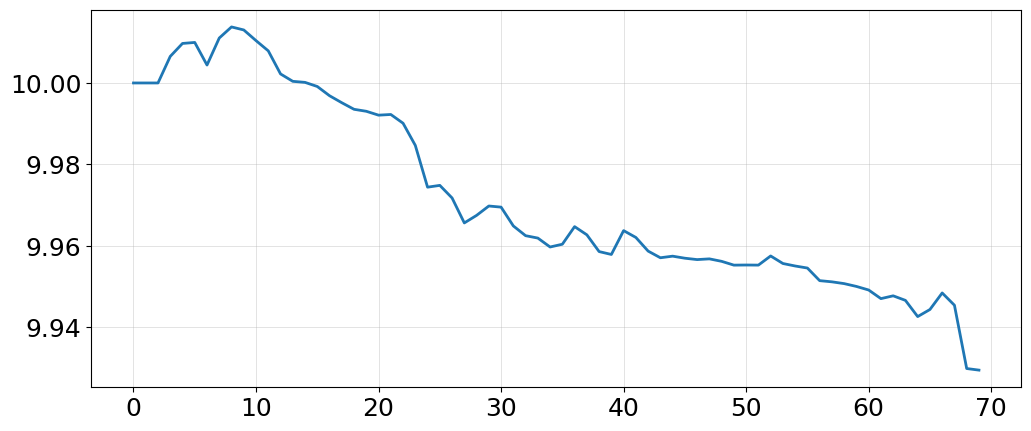

In [78]:
plt.plot(theta[:,0])

In [21]:
def smooth_max(k_smooth, x):

    # Compute lateral noise
    smooth_max = np.max(x) + 1/k_smooth*np.log(sum(np.exp(k_smooth*(x-np.max(x)))))
    
    # Return
    return smooth_max


In [22]:
import random

In [30]:
x = np.linspace(0, 10, 101)
y = np.zeros(101)

for i,_ in enumerate(x):
    y[i] = -(x[i]-5)**2 + random.random()

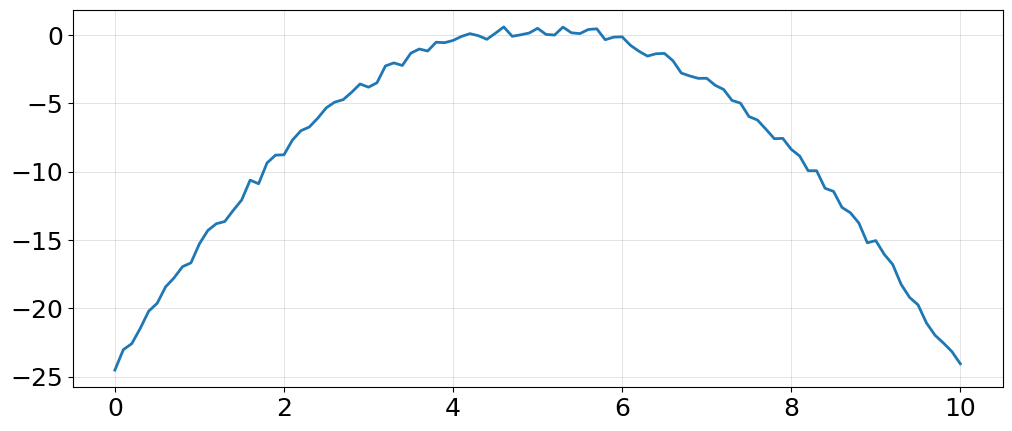

In [31]:
plt.plot(x, y)